In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import pandas as pd

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


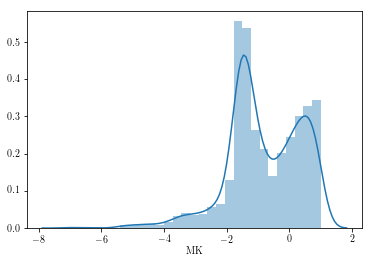

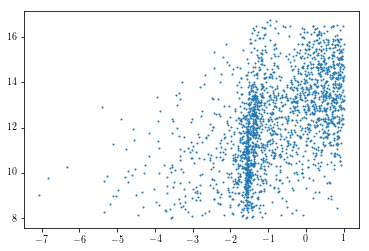

In [2]:
#Instead of using this generated data, lets run straight on the TRILEGAL sample!
sfile = 'file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V
#Make some cuts
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]
#Calculate absolute magnitude (no extinction)
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0
#Apply a cut so the exponential fits better
df = df.loc[df.MK < 1.]
sns.distplot(df.MK)
plt.show()
plt.scatter(df.MK,df.K,s=1)
plt.show()


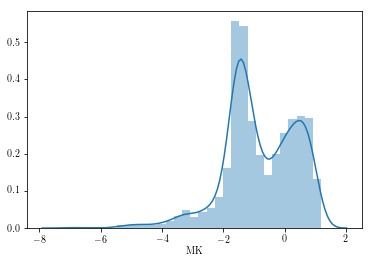

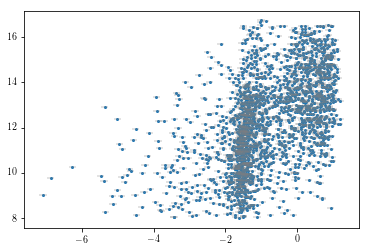

In [13]:
err = np.ones(len(df.MK))*.1
d = df.MK + np.random.randn(len(df))*err
sns.distplot(d)
plt.show()
plt.scatter(d,df.K,s=4)
plt.errorbar(d,df.K,xerr=err,fmt='none',c='grey',alpha=.3)
plt.show()


In [4]:
code = '''
functions {
    real logexp(real x, real lambd) {
        return log(lambd) - lambd*x;
        }
    real lognormexp(real x, real c0, real c1, real lambd) {
        return log(-lambd/(c1^(-lambd)-c0^(-lambd))) - lambd*x;
    }   
    real logposexp(real x, real c0, real c1, real lambd) {
        return log(lambd/(c1^(lambd)-c0^(lambd))) + lambd*x;
    }
}
data {
    int<lower = 0> N;
    real d[N];
    real err[N];
    real c1;
    real c0;
}
parameters {
    real lambd;
    real mu;
    real <lower=0.> sig;
    real <lower=0.,upper=1.> Q;
    real d_true[N];
}
model {
    d_true ~ normal(d, err);

    lambd ~ normal(0.2,0.1);
    mu ~ normal(-3.,1.);
    sig ~ normal(1.,0.1);
    Q ~ normal(0.5,.1);

    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(d_true[n] | mu, sig),
            logposexp(d_true[n] ,c0, c1, lambd));
}
generated quantities{
    vector[N] post_prob;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(d[n] | mu, sig);
        ll_bg = log(1-Q) + logposexp(d[n], c0, c1, lambd);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
    }
}

'''
sm = pystan.StanModel(model_code = code, model_name='exp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL exp_fafe86d4ac345bea5e624b9c99f27f1a NOW.


In [14]:
dat = {'N': len(d),
      'd': d,
      'err' : err,
      'c1' : np.exp(d.max()),
      'c0' : np.exp(d.min())}
fit = sm.sampling(data=dat, iter=3000, chains=1)


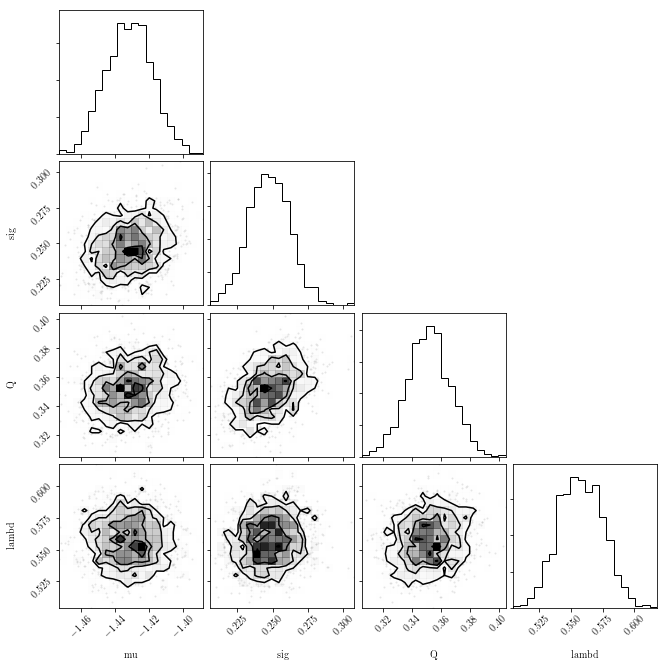

In [15]:
import corner
trace = fit.extract()
chain = np.array([trace['mu'],trace['sig'],trace['Q'],trace['lambd']])
corner.corner(chain.T,labels=['mu','sig','Q','lambd'])
plt.show()

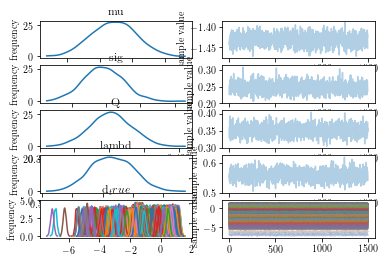

In [16]:
fit.plot(pars=['mu','sig','Q','lambd','d_true'])
plt.show()

In [17]:
trace = fit.extract()
Slambd = np.median(trace['lambd'])
Smu = np.median(trace['mu'])
Ssig = np.median(trace['sig'])
SQ = np.median(trace['Q'])
tpp = trace['post_prob']
post_prob = np.sum(tpp,axis=0)/tpp.shape[0]

bg = (Slambd/(np.exp(d.max())**Slambd - np.exp(d.min())**Slambd))*np.exp(d*Slambd)
fg = (1/np.sqrt(2*np.pi*Ssig**2))*np.exp(-(d-Smu)**2/(2*Ssig**2))
L = SQ*fg + (1-SQ)*bg

Text(0,0.5,u'Units arbitrary')

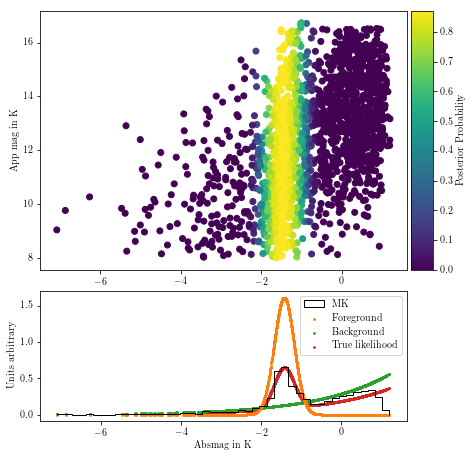

In [18]:
left, bottom, width, height = 0.1, 0.45, 0.85, 0.60
fig = plt.figure(1, figsize=(6,6))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])
cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(d,df.K,c=post_prob)
fig.colorbar(c, cax=cax, label='Posterior Probability')
xax.hist(d, histtype='step', bins='sqrt',color='k',normed=True,zorder=1000)

xax.scatter(d,fg,s=3,label='Foreground', zorder=999)
xax.scatter(d,bg,s=3,label='Background', zorder=998)
xax.scatter(d, L,s=3,label='True likelihood', zorder=997)
xax.legend()

xax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')